In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import sacc
import yaml
import numcosmo_py as ncm
from chainconsumer import ChainConsumer, Chain, PlotConfig, Truth

In [3]:
def load_yaml_file(yaml_file: str) -> dict:
    with open(yaml_file, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)
    
def get_6x2pt_sacc(run_names: list) -> list:
    sacc_data_list = []
    for run_name in run_names:
        run_name_split = run_name.split('_')
        run_name_directory = '_'.join(run_name_split[2:])
        sacc_file = f"./runs/{run_name_directory}/sacc_files/{run_name}.sacc"
        try:
            sacc_data = sacc.Sacc.load_fits(sacc_file)
            sacc_data_list.append(sacc_data)
        except FileNotFoundError:
            print(f"Warning: File {sacc_file} not found. Skipping this run.")
        except Exception as e:
            print(f"Error loading {sacc_file}: {e}. Skipping this run.")
    
    return sacc_data_list

def get_sacc_plots(list_run_name_):
    sacc_list = []
    for _run_name in list_run_name_:
        try:
            sacc_data = get_6x2pt_sacc([_run_name])  # Pass a list with a single run name
            sacc_list.append(sacc_data[0])  # Extract the first (and only) element
        except Exception as e:
            print(f"Error loading SACC data for {_run_name}: {e}")
    
    if sacc_list:
        get_tracer_plots(sacc_list, list_run_name_)
        get_c_ell_plots(sacc_list, list_run_name_)
        get_correlation_plot(sacc_list, list_run_name_)
    else:
        print("No valid SACC data found to plot.")

def get_tracer_plots(list_sacc_data_, list_run_names):
    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(24, 12))
    colors = {'lens': 'C3', 'src': 'C4', 'spec_bgs': 'C0', 'spec_lrg': 'C1', 'spec_elg': 'C2'}
    
    # Define line styles for each run
    line_styles = ['-', '--', '-.', ':']
    
    # Verifica se o número de SACC data e run names coincide
    if len(list_sacc_data_) != len(list_run_names):
        raise ValueError("O número de SACC data e run names deve ser o mesmo.")
    
    # Itera sobre cada SACC data e run name
    for idx, (_sacc_data_, run_name) in enumerate(zip(list_sacc_data_, list_run_names)):
        # Define o estilo de linha para este run
        line_style = line_styles[idx % len(line_styles)]
        
        for tr in _sacc_data_.tracers:
            try:
                tracer = _sacc_data_.get_tracer(tr)
                if tr.startswith("lens"):
                    ax[0].plot(tracer.z, tracer.nz, 
                               label=f'LSST lens', color=colors['lens'], 
                               linestyle=line_style, alpha=0.7)
                if tr.startswith("src"):
                    ax[1].plot(tracer.z, tracer.nz, 
                               label=f'LSST source', color=colors['src'], 
                               linestyle=line_style, alpha=0.7)
                if tr.startswith("spec_bgs"):
                    ax[2].plot(tracer.z, tracer.nz, 
                               label=f'DESI BGS', color=colors['spec_bgs'], 
                               linestyle=line_style, alpha=0.7)
                if tr.startswith("spec_lrg"):
                    ax[2].plot(tracer.z, tracer.nz, 
                               label=f'DESI LRG', color=colors['spec_lrg'], 
                               linestyle=line_style, alpha=0.7)
                if tr.startswith("spec_elg"):
                    ax[2].plot(tracer.z, tracer.nz, 
                               label=f'DESI ELG', color=colors['spec_elg'], 
                               linestyle=line_style, alpha=0.7)
            except Exception as e:
                print(f"Error processing tracer {tr} for run {run_name}: {e}")
    
    # Configurações dos subplots
    titles = ['LSST-LIKE Lens sample', 'LSST-LIKE Source sample', 'DESI-LIKE sample']
    for i in range(3):
        ax[i].set_ylabel('dN/dz')
        ax[i].set_xlabel('z')
        ax[i].set_xlim(0, 2.5)
        ax[i].grid(True, linestyle='--', alpha=0.6)
        ax[i].set_title(titles[i])
        
        # Remove legendas duplicadas
        handles, labels = ax[i].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax[i].legend(by_label.values(), by_label.keys(), loc='upper right', frameon=False)
    
    plt.tight_layout()
    plt.show()

def c_ell_auxiliary_plot(_list_tracer_comb_, list_sacc_data_, list_run_names):
    size = len(_list_tracer_comb_)
    if size == 0:
        print("No tracer combinations found.")
        return
    
    # Verifica se o número de SACC data e run names coincide
    if len(list_sacc_data_) != len(list_run_names):
        raise ValueError("O número de SACC data e run names deve ser o mesmo.")
    
    # Define estilos de linha e cores para cada run
    line_styles = ['-', '--', '-.', ':']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Cores básicas
    
    # Configuração dos subplots
    nrows = (size // 5) + 1 if size % 5 != 0 else size // 5
    fig, axs = plt.subplots(nrows, 5, figsize=(24, 4 * nrows))
    
    # Se axs for 1D, transforme-o em 2D para consistência
    if nrows == 1:
        axs = axs.reshape(1, -1)
    
    # Itera sobre cada combinação de tracers
    for i, (t1, t2) in enumerate(_list_tracer_comb_):
        row = i // 5
        col = i % 5
        
        for idx, (_sacc_data_, run_name) in enumerate(zip(list_sacc_data_, list_run_names)):
            # Verifica se a combinação de tracers existe neste run
            if (t1 in _sacc_data_.tracers) and (t2 in _sacc_data_.tracers):
                try:
                    # Define o estilo de linha e cor para este run
                    line_style = line_styles[idx % len(line_styles)]
                    color = colors[idx % len(colors)]
                    
                    # Obtém os dados C_ell
                    l1, cl1, cov1 = _sacc_data_.get_ell_cl(None, t1, t2, return_cov=True)
                    err1 = np.sqrt(np.diag(cov1))
                    
                    # Plota os dados no subplot correto
                    axs[row, col].errorbar(l1, cl1, err1, fmt=line_style, color=color, label=f'{run_name}', alpha=0.8)
                except:
                    # Define o estilo de linha e cor para este run
                    line_style = line_styles[idx % len(line_styles)]
                    color = colors[idx % len(colors)]
                    
                    # Obtém os dados C_ell
                    l1, cl1 = _sacc_data_.get_ell_cl(None, t1, t2, return_cov=False)
                    
                    # Plota os dados no subplot correto
                    axs[row, col].plot(l1, cl1, color=color, label=f'{run_name}', alpha=0.8)
        
        # Configurações do subplot
        axs[row, col].set_title(f'{t1} - {t2}')
        axs[row, col].set_xlim(20, 2000)
        axs[row, col].set_xscale('log')
        axs[row, col].set_yscale('log')
        axs[row, col].set_xlabel('$\ell$')
        axs[row, col].set_ylabel('$\ell C_\ell [10^-9]$')
        axs[row, col].grid(True, linestyle='--', alpha=0.6)
        axs[row, col].legend(loc='upper right', frameon=False)
    
    # Oculta subplots não utilizados
    for i in range(size, nrows * 5):
        row = i // 5
        col = i % 5
        axs[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

def get_c_ell_plots(list_sacc_data_, list_run_names):
    if len(list_sacc_data_) == 0:
        print("No SACC data provided.")
        return
    
    # Coleta todas as combinações de tracers únicas em todos os runs
    all_tracer_combinations = set()
    for _sacc_data_ in list_sacc_data_:
        all_tracer_combinations.update(_sacc_data_.get_tracer_combinations())
    
    # Converte o conjunto de combinações em uma lista
    all_tracer_combinations = list(all_tracer_combinations)
    
    # Separa as combinações de tracers por tipo
    lens_x_lens = []
    spec_x_lens = []
    spec_x_spec = []
    lens_x_src = []
    spec_x_src = []
    src_x_src = []
    
    for t1, t2 in all_tracer_combinations:
        if t1.startswith("lens") and t2.startswith("lens"):
            lens_x_lens.append((t1, t2))
        if t1.startswith("spec") and t2.startswith("lens"):
            spec_x_lens.append((t1, t2))
        if t1.startswith("spec") and t2.startswith("spec"):
            spec_x_spec.append((t1, t2))
        if t1.startswith("lens") and t2.startswith("src"):
            lens_x_src.append((t1, t2))
        if t1.startswith("spec") and t2.startswith("src"):
            spec_x_src.append((t1, t2))
        if t1.startswith("src") and t2.startswith("src"):
            src_x_src.append((t1, t2))
    
    # Plota as combinações de tracers
    c_ell_auxiliary_plot(lens_x_lens, list_sacc_data_, list_run_names)
    c_ell_auxiliary_plot(spec_x_lens, list_sacc_data_, list_run_names)
    c_ell_auxiliary_plot(spec_x_spec, list_sacc_data_, list_run_names)
    c_ell_auxiliary_plot(lens_x_src, list_sacc_data_, list_run_names)
    c_ell_auxiliary_plot(spec_x_src, list_sacc_data_, list_run_names)
    c_ell_auxiliary_plot(src_x_src, list_sacc_data_, list_run_names)

def get_correlation_plot(list_sacc_data_, list_run_names):
    """
    Plota a matriz de correlação para cada SACC data, diferenciando blocos com base nos índices dos tracers
    e adicionando os nomes das combinações nos eixos x e y.

    Args:
        list_sacc_data_: Lista de objetos sacc.
        list_run_names: Lista de nomes das runs correspondentes.
    """
    # Verifica se o número de SACC data e run names coincide
    if len(list_sacc_data_) != len(list_run_names):
        raise ValueError("O número de SACC data e run names deve ser o mesmo.")
    
    # Número de runs
    num_runs = len(list_sacc_data_)
    
    # Configuração dos subplots
    fig, axs = plt.subplots(1, num_runs, figsize=(10 * num_runs, 8))  # Ajuste o tamanho conforme necessário
    
    # Se houver apenas um run, axs não será uma lista, então transformamos em uma lista
    if num_runs == 1:
        axs = [axs]
    
    # Itera sobre cada SACC data e run name
    for idx, (_sacc_data_, run_name) in enumerate(zip(list_sacc_data_, list_run_names)):
        try:
            # Calcula a matriz de correlação
            cov = _sacc_data_.covariance.dense
            sig = np.sqrt(cov.diagonal())
            corr = cov / np.outer(sig, sig)
            
            # Plota a matriz de correlação no subplot correspondente
            im = axs[idx].imshow(corr, vmin=0, vmax=1, cmap='gnuplot2_r')
            plt.colorbar(im, ax=axs[idx], label='Correlation')
            axs[idx].set_title(f'Correlation Matrix ({run_name})')
            
            # Obtém os rótulos para os eixos x e y
            labels = []
            for dt in _sacc_data_.get_data_types():
                if dt == "galaxy_density_cl":
                    dt = "$C_{gg}(l)$"
                elif dt == "galaxy_shearDensity_cl_e":
                    dt = "$C_{g\gamma}(l)$"
                elif dt == "galaxy_shear_cl_ee":
                    dt = "$C_{\gamma\gamma}(l)$"
                label = f"{dt}"
                labels.append(label)

            # Adiciona linhas divisórias para diferenciar os blocos
            tracer_comb = ["lens"]
            block_indices = []
            for dt in _sacc_data_.get_data_types():
                for tr in _sacc_data_.get_tracer_combinations(dt):
                    # Obtém os índices correspondentes a esta combinação de tracers
                    indices = _sacc_data_.indices(dt, tr)
                    print(f"Indices for {tr}: {indices}")
                if len(indices) > 0:
                    block_indices.append(indices[-1]+ 0.5)  # Fim do bloco desta combinação
            
            # Calcula as posições dos ticks (meio de cada bloco)
            tick_positions = []
            start = 0
            for block in block_indices:
                mid = (start + block) // 2  # Ponto médio do bloco
                tick_positions.append(mid)
                start = block

            # Remove o último índice, pois não precisamos de uma linha no final da matriz
            block_indices = block_indices[:-1]

            # Define os ticks e rótulos nos eixos x e y
            axs[idx].set_xticks(tick_positions)
            axs[idx].set_yticks(tick_positions)
            axs[idx].set_xticklabels(labels, rotation=90, fontsize=10)  # Rótulos no eixo x
            axs[idx].set_yticklabels(labels, fontsize=10)  # Rótulos no eixo y

            # Adiciona linhas divisórias para diferenciar os blocos
            for block in block_indices:
                axs[idx].axvline(x=block, color='grey', linestyle='--', linewidth=0.5)
                axs[idx].axhline(y=block, color='grey', linestyle='--', linewidth=0.5)
        except Exception as e:
            print(f"Error processing correlation matrix for run {run_name}: {e}")
    
    plt.tight_layout()
    plt.show()


def read_augurs_output(_run_name_):
    run_name_split = _run_name_.split('_')
    run_name_directory = '_'.join(run_name_split[2:])
    
    print(f"Reading data for run {run_name_directory}...")
    fisher_output_path = f"./6x2pt/{run_name_directory}/fisher_output/{_run_name_}"
    bias_values = None

    # Read bias.dat if it exists
    try:
        with open(f'{fisher_output_path}/bias.dat', "r") as f:
            lines = f.readlines()
            if len(lines) > 1:  # Ensure there are at least two lines
                bias_values = np.array(lines[1].strip().split(), dtype=float)
    except FileNotFoundError:
        print(f"Warning: bias.dat not found for run {_run_name_}.")
    except Exception as e:
        print(f"Error reading bias.dat for run {_run_name_}: {e}")

    # Read fiducials.dat
    values_params = []
    parameter_names = []
    try:
        with open(f'{fisher_output_path}/fiducials.dat', "r") as f:
            lines = f.readlines()
            if len(lines) >= 2:  # Ensure there are at least two lines
                # First line contains parameter names
                parameter_names = lines[0].strip().split()
                # Second line contains parameter values
                values_params = [float(val) for val in lines[1].strip().split()]
    except FileNotFoundError:
        raise FileNotFoundError(f"fiducials.dat not found for run {_run_name_}.")
    except Exception as e:
        raise Exception(f"Error reading fiducials.dat for run {_run_name_}: {e}")

    # Read fisher.dat
    try:
        fisher = np.loadtxt(f'{fisher_output_path}/fisher.dat')
    except FileNotFoundError:
        raise FileNotFoundError(f"fisher.dat not found for run {_run_name_}.")
    except Exception as e:
        raise Exception(f"Error reading fisher.dat for run {_run_name_}: {e}")

    # Convert to DataFrames
    values_params = np.array(values_params)
    values_bias_params = values_params + bias_values if bias_values is not None else values_params
    fisher_pd = pd.DataFrame(fisher, columns=parameter_names, index=parameter_names)
    values_bias_params = pd.DataFrame(values_bias_params, index=parameter_names)
    values_params = pd.DataFrame(values_params, index=parameter_names)

    return parameter_names, values_params, values_bias_params, fisher_pd

def auxiliar_chain_plots(c, idx, run_name, _list_of_parameters):
    if not _list_of_parameters:
        print("A lista de parâmetros está vazia. Nada para plotar.")
        return
    
    # Define cores ou estilos de linha para cada run
    colors = ['blue', 'red', 'green', 'orange', 'grey']  # Cores para diferentes runs
    line_styles = ['-', '--', '-.', ':']  # Estilos de linha para diferentes runs
    run_name_filter = {
        'run_0_3x2pt_LSST': "3x2pt_LSST",
        'run_1_3x2pt_LSST': "3x2pt_LSST",
        'run_0_6x2pt_LSST_DESI_BGS_0.2bin': "6x2pt_LSST_DESI_BGS",
        'run_0_6x2pt_LSST_DESI_LRG_0.2bin': "6x2pt_LSST_DESI_LRG",
        'run_0_6x2pt_LSST_DESI_ELG_0.2bin': "6x2pt_LSST_DESI_ELG",
        'run_0_6x2pt_LSST_DESI_FULL_0.2bin': "6x2pt_LSST_DESI_0.2bin",
        'run_0_6x2pt_LSST_DESI_FULL_0.1bin': "6x2pt_LSST_DESI_0.1bin",
    }

    _list_of_parameters_filt_disct = {
        'Omega_c': "$\Omega_c$",
        'Omega_b': "$\Omega_b$",
        'sigma8': "$\sigma_8$",
        'n_s': "$n_s$",
        'h': "$h$",
        'w0': "$w_0$",
        'wa': "$w_a$",
        'm_nu': "$m_{\nu}$",
        'alphaz': "$\eta_1$",
        'ia_bias': "$IA_{bias}$",
    }
    try: 
        _list_of_parameters_filter = [_list_of_parameters_filt_disct[param] for param in _list_of_parameters]
    except:
        _list_of_parameters_filter = _list_of_parameters
    # Lê os dados do run atual
    parameter_names, values_params, values_bias_params, fisher_pd = read_augurs_output(run_name)
    
    # Filtra a matriz de Fisher para os parâmetros desejados
    fisher_pd = fisher_pd.loc[_list_of_parameters, _list_of_parameters]
    invert_fisher = np.linalg.inv(fisher_pd)

    # Cria a cadeia de Markov para o run atual
    df_chain = Chain.from_covariance(values_params.loc[_list_of_parameters].values.flatten(), invert_fisher, _list_of_parameters_filter, run_name_filter[run_name], color = colors[idx % len(colors)], linestyle = line_styles[idx % len(line_styles)])
    
    # Adiciona a cadeia ao ChainConsumer
    c.add_chain(df_chain)
    
    # Adiciona os valores verdadeiros (truths) ao gráfico
    # FIXME: Adicionar valores verdadeiros
    # if len(list_run_names) > 0:
    #     parameter_names, values_params, _, _ = read_augurs_output(list_run_names[0])
    #     for i in range(len(values_params)):
    #         c.add_truth(Truth(location={parameter_names[i]: values_params[i]}))
    


def get_chain_plots(list_run_names):
    if len(list_run_names) == 0:
        print("Nenhum run fornecido.")
        return
            
    c = ChainConsumer()
    for idx, run_name in enumerate(list_run_names):
        parameter_names, values_params, values_bias_params, fisher_pd = read_augurs_output(run_name)
        print(f"Parâmetros disponíveis: {parameter_names}")
        
        # Define os grupos de parâmetros
        source_params = ['ia_bias', 'alphaz']
        cosmo_vanilla_params = ['Omega_c', 'Omega_b','sigma8', 'n_s', 'h']
        cosmo_chocolate_params = ['Omega_c',  'Omega_b', 'sigma8', 'n_s', 'h', 'w0', 'wa']
        cosmo_strawberry_params = ['Omega_c', 'Omega_b', 'sigma8', 'n_s', 'h', 'm_nu']
        cosmo_full_params = ['Omega_c',  'Omega_b', 'sigma8', 'n_s', 'h', 'w0', 'wa', 'm_nu']
        lens_dist_params = [param for param in parameter_names if param.startswith('lens') and (param.endswith('delta_z') or param.endswith('sigma_z'))]
        src_dist_params = [param for param in parameter_names if param.startswith('src')]
        
        # Plota os gráficos com sobreposição para cada grupo de parâmetros
        # Check if all parameters from each group are in parameter_names
        # if all(param in parameter_names for param in cosmo_full_params):
        #     print("Full!")
        #     auxiliar_chain_plots(c, idx, run_name, cosmo_full_params)
        # elif all(param in parameter_names for param in cosmo_strawberry_params):
        #     print("Strawberry!")
        #     auxiliar_chain_plots(c, idx, run_name, cosmo_strawberry_params)
        # elif all(param in parameter_names for param in cosmo_chocolate_params):
        #     print("Chocolate!")
        #     auxiliar_chain_plots(c, idx, run_name, cosmo_chocolate_params)
        # else:
        #     print("Vanilla!")
        #     auxiliar_chain_plots(c, idx, run_name, cosmo_vanilla_params)

        auxiliar_chain_plots(c, idx, run_name, lens_dist_params)
        # auxiliar_chain_plots(c, idx, run_name, src_dist_params)
        #auxiliar_chain_plots(c, idx, run_name, source_params)

    # Configura e plota o gráfico
    try:
        if len(c._chains) > 0:  # Verifica se há cadeias para plotar
            c.set_plot_config(PlotConfig(max_ticks=4, label_font_size = 15, tick_font_size=13))
            fig = c.plotter.plot()
        else:
            print("Nenhuma cadeia válida para plotar.")
    except Exception as e:
        print(f"Erro ao plotar as cadeias: {e}")

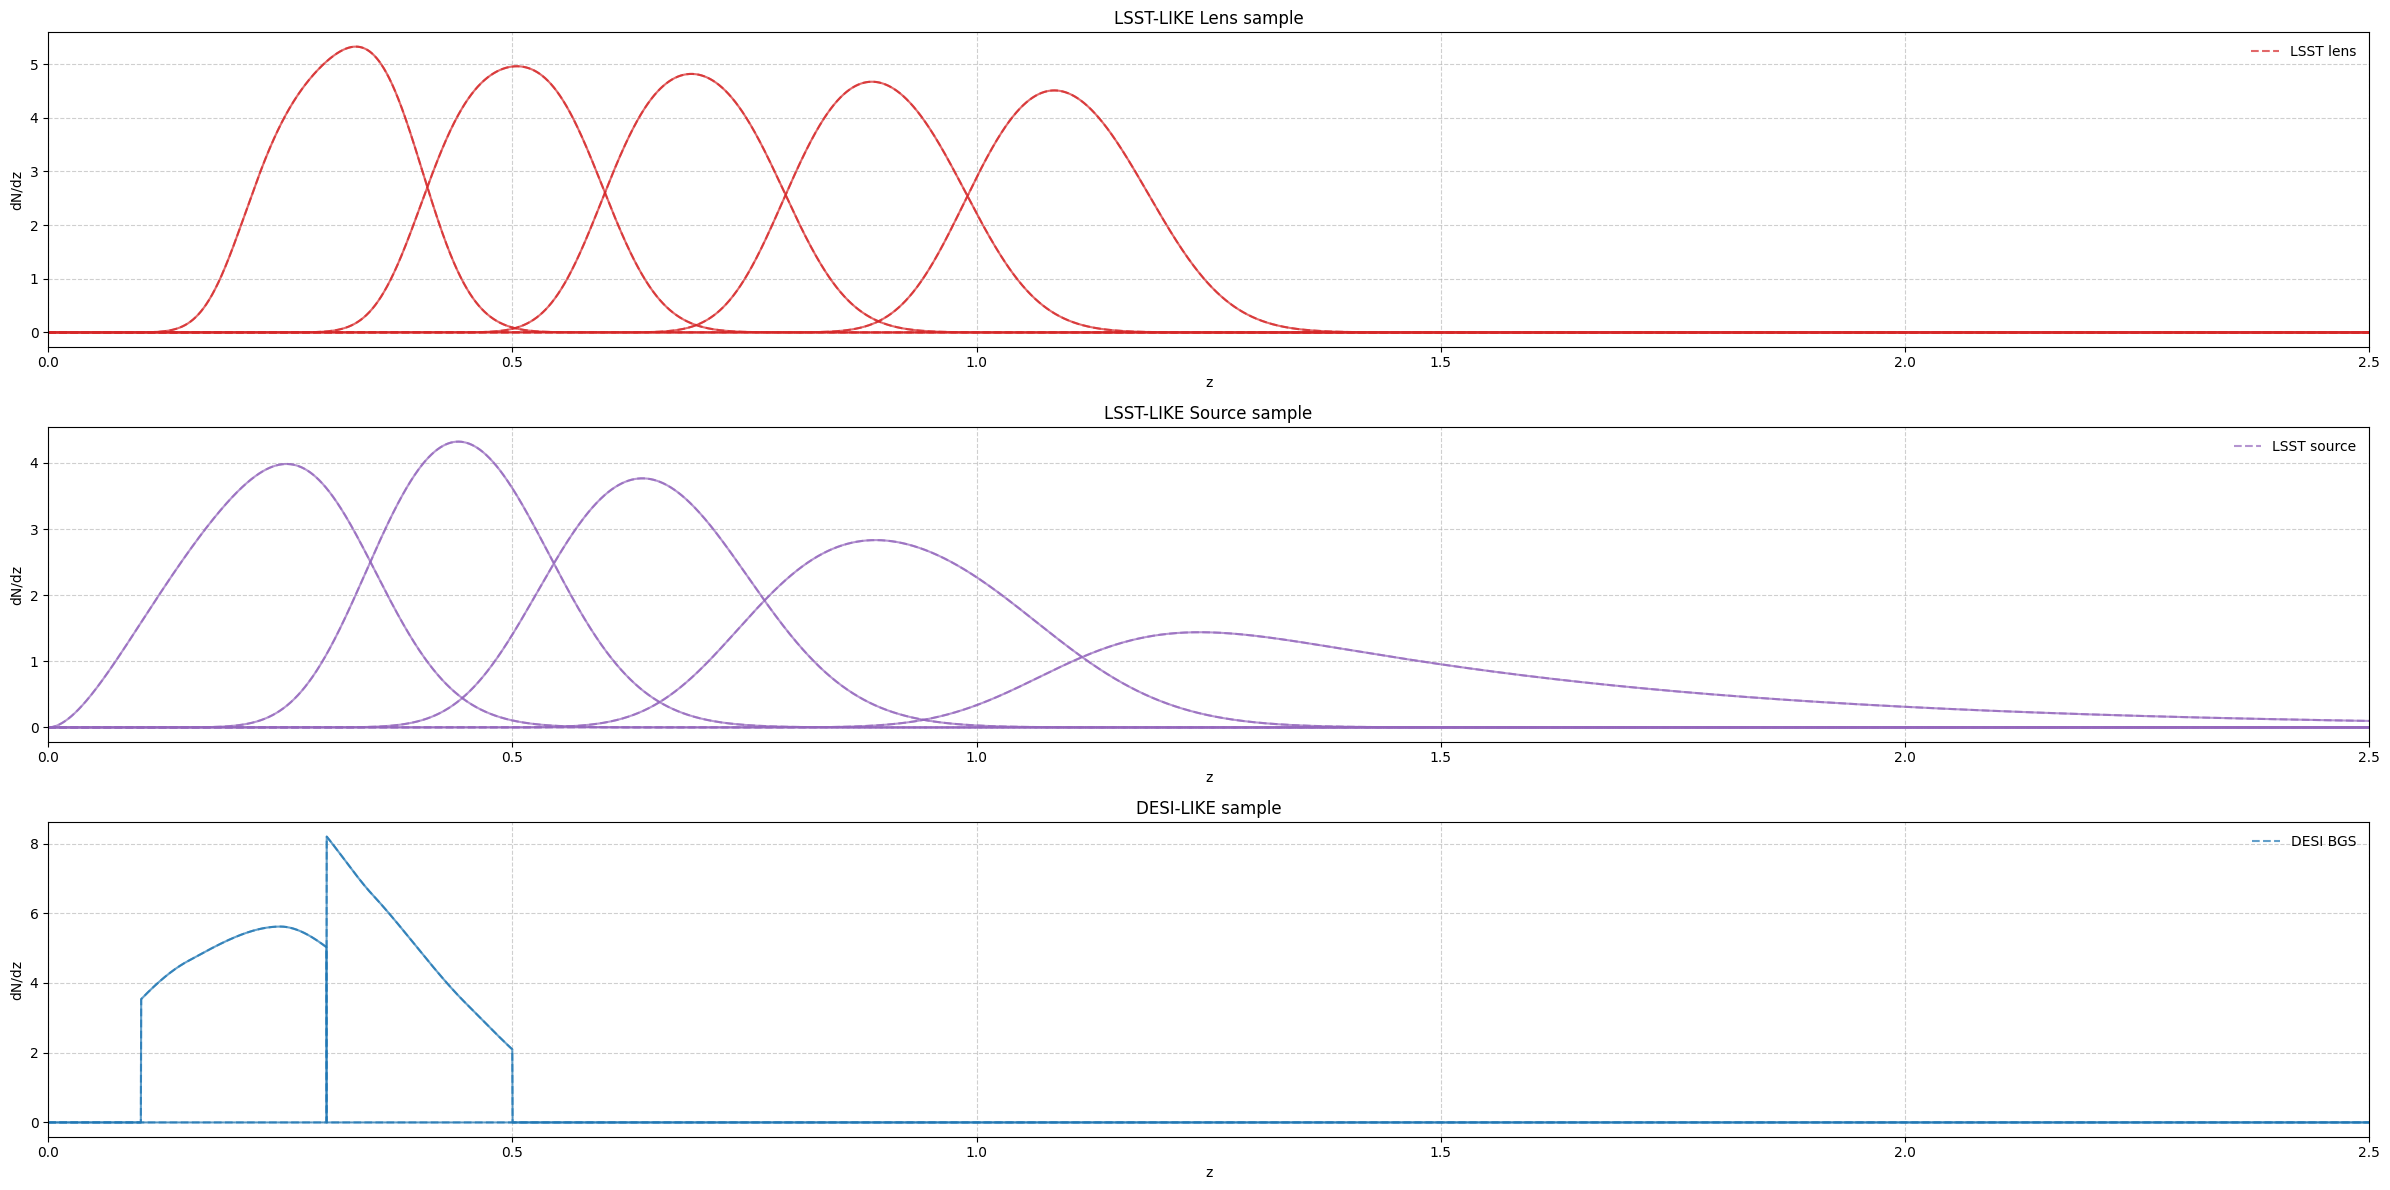

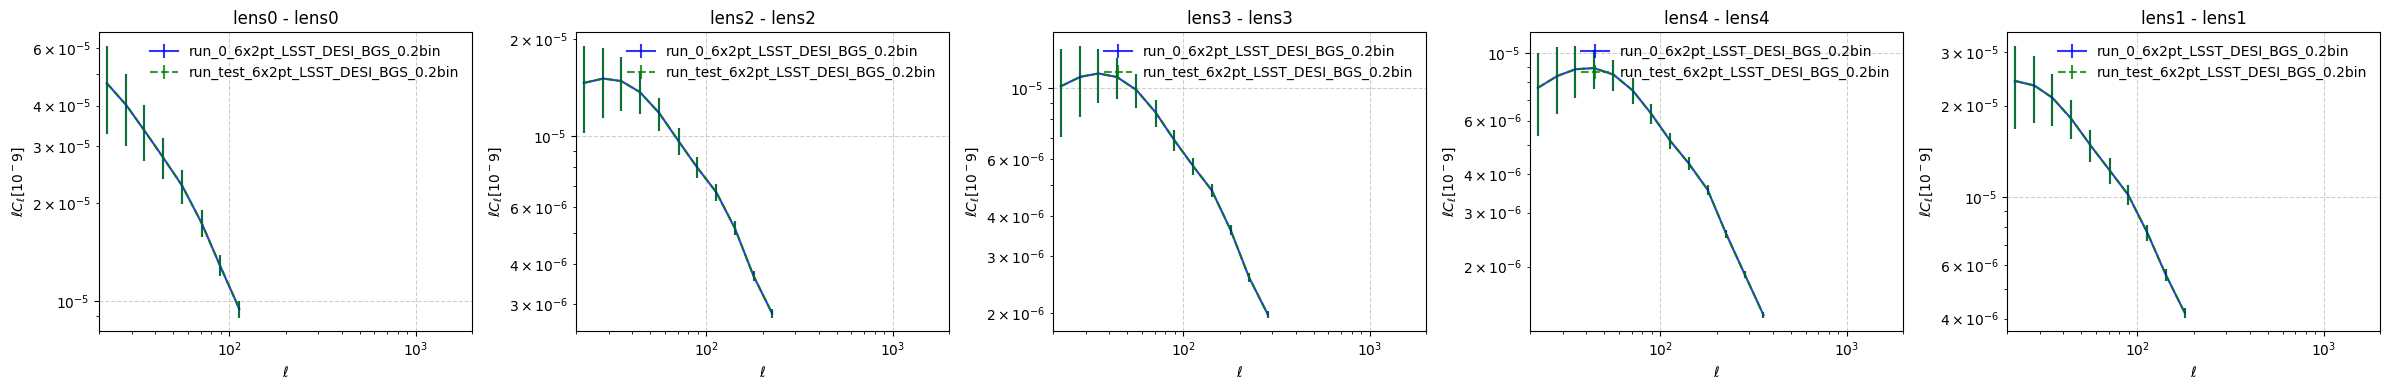

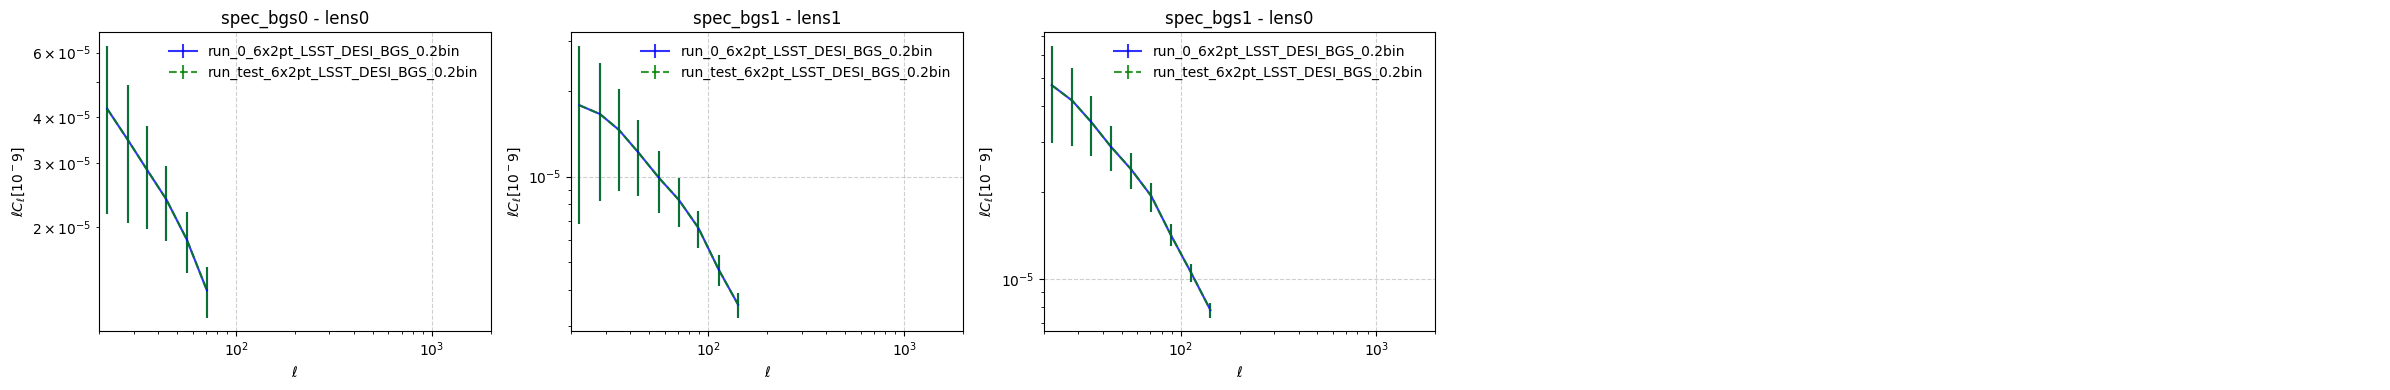

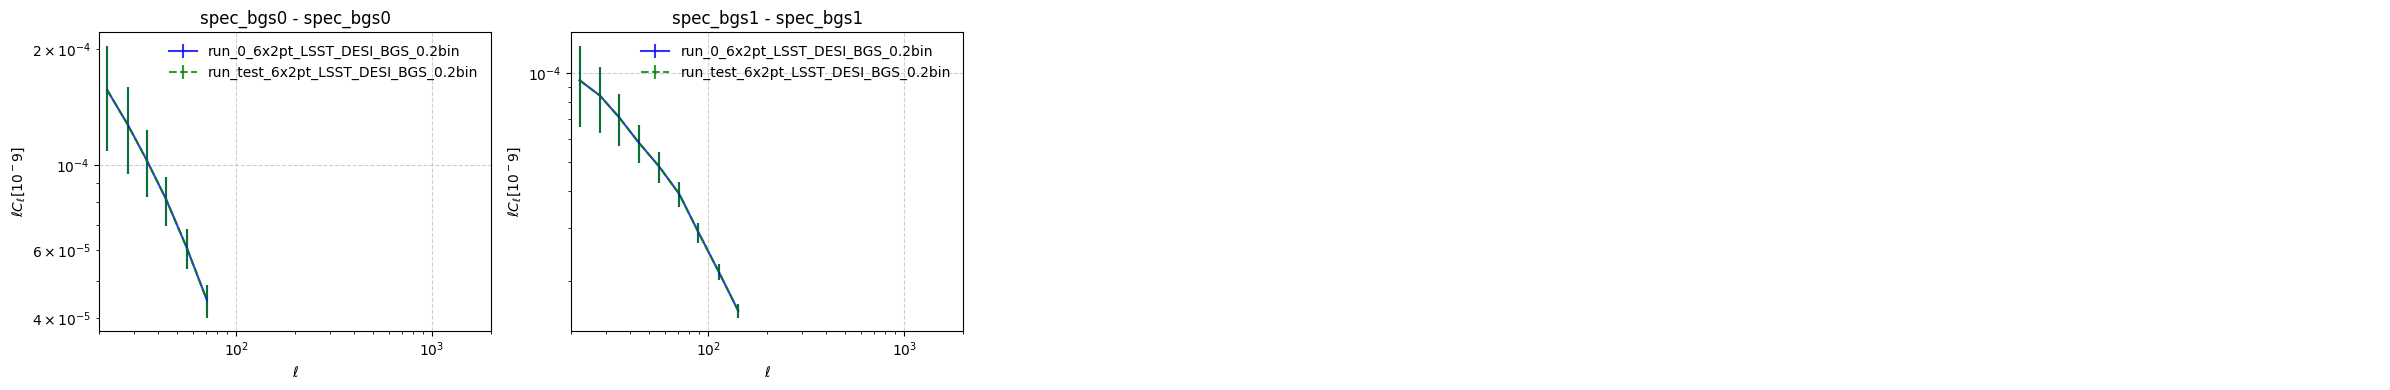

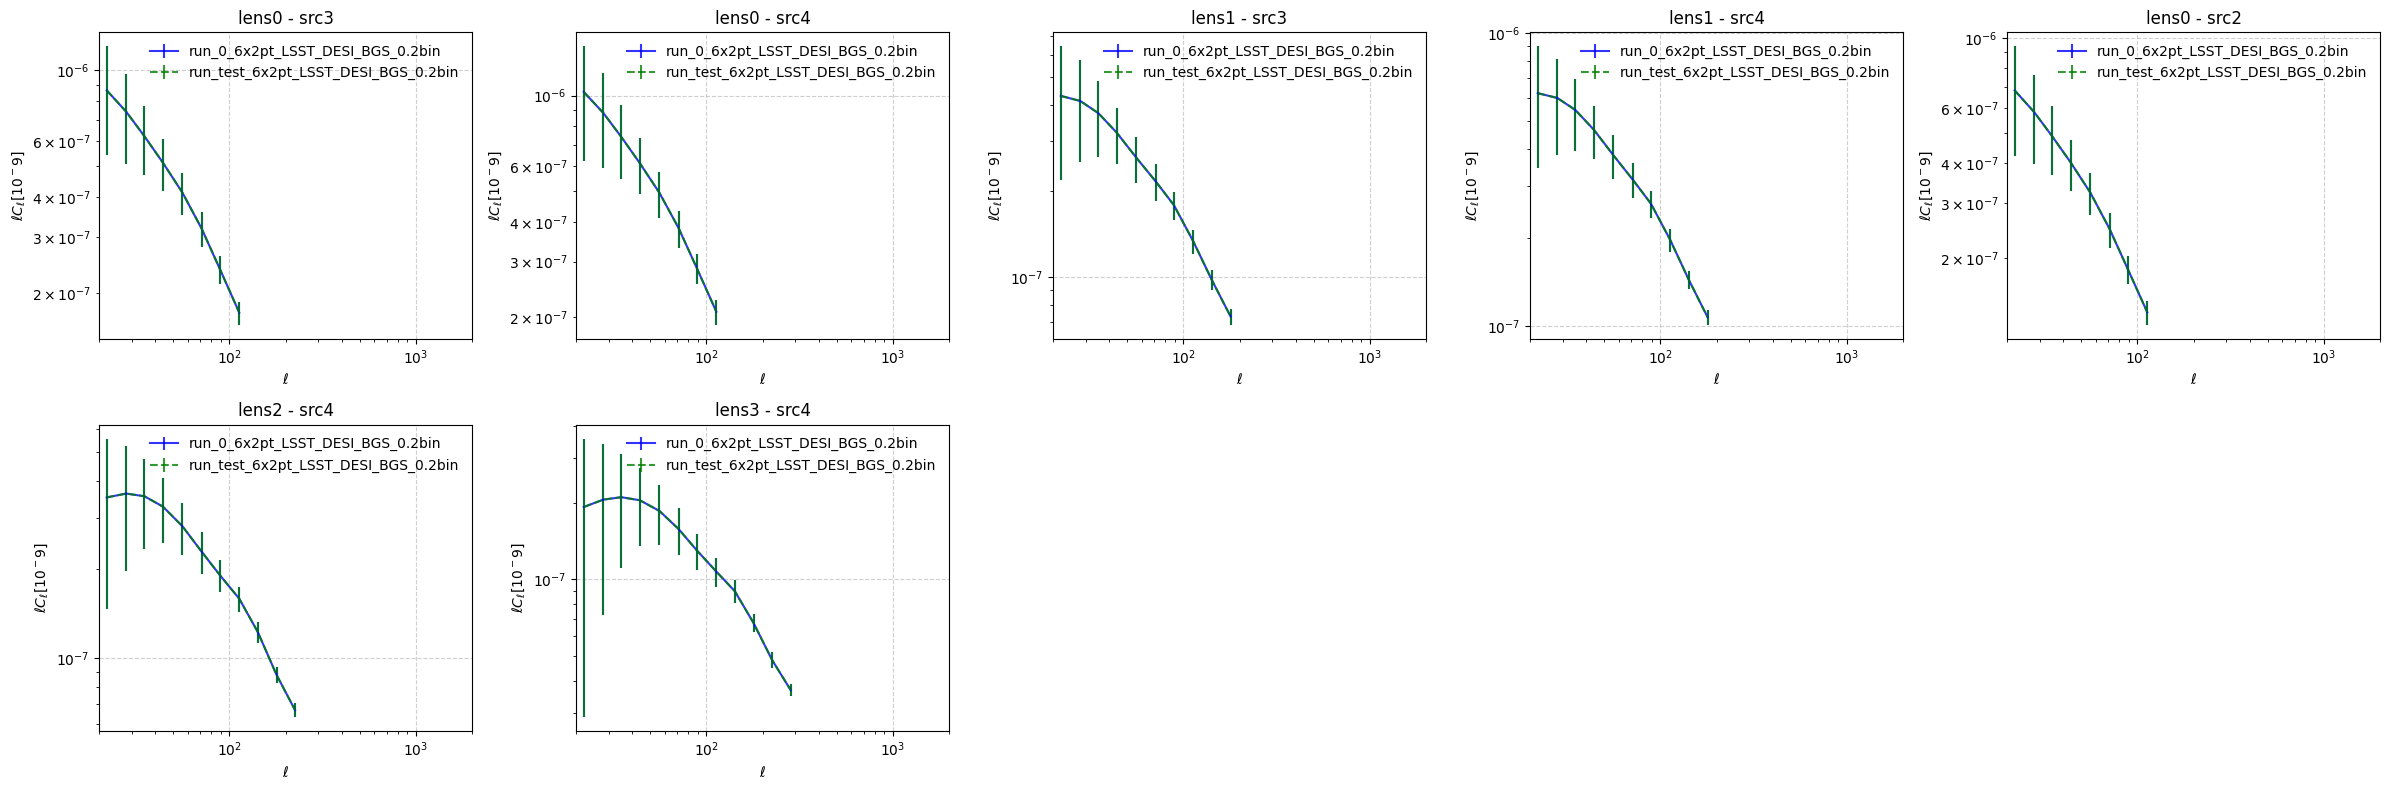

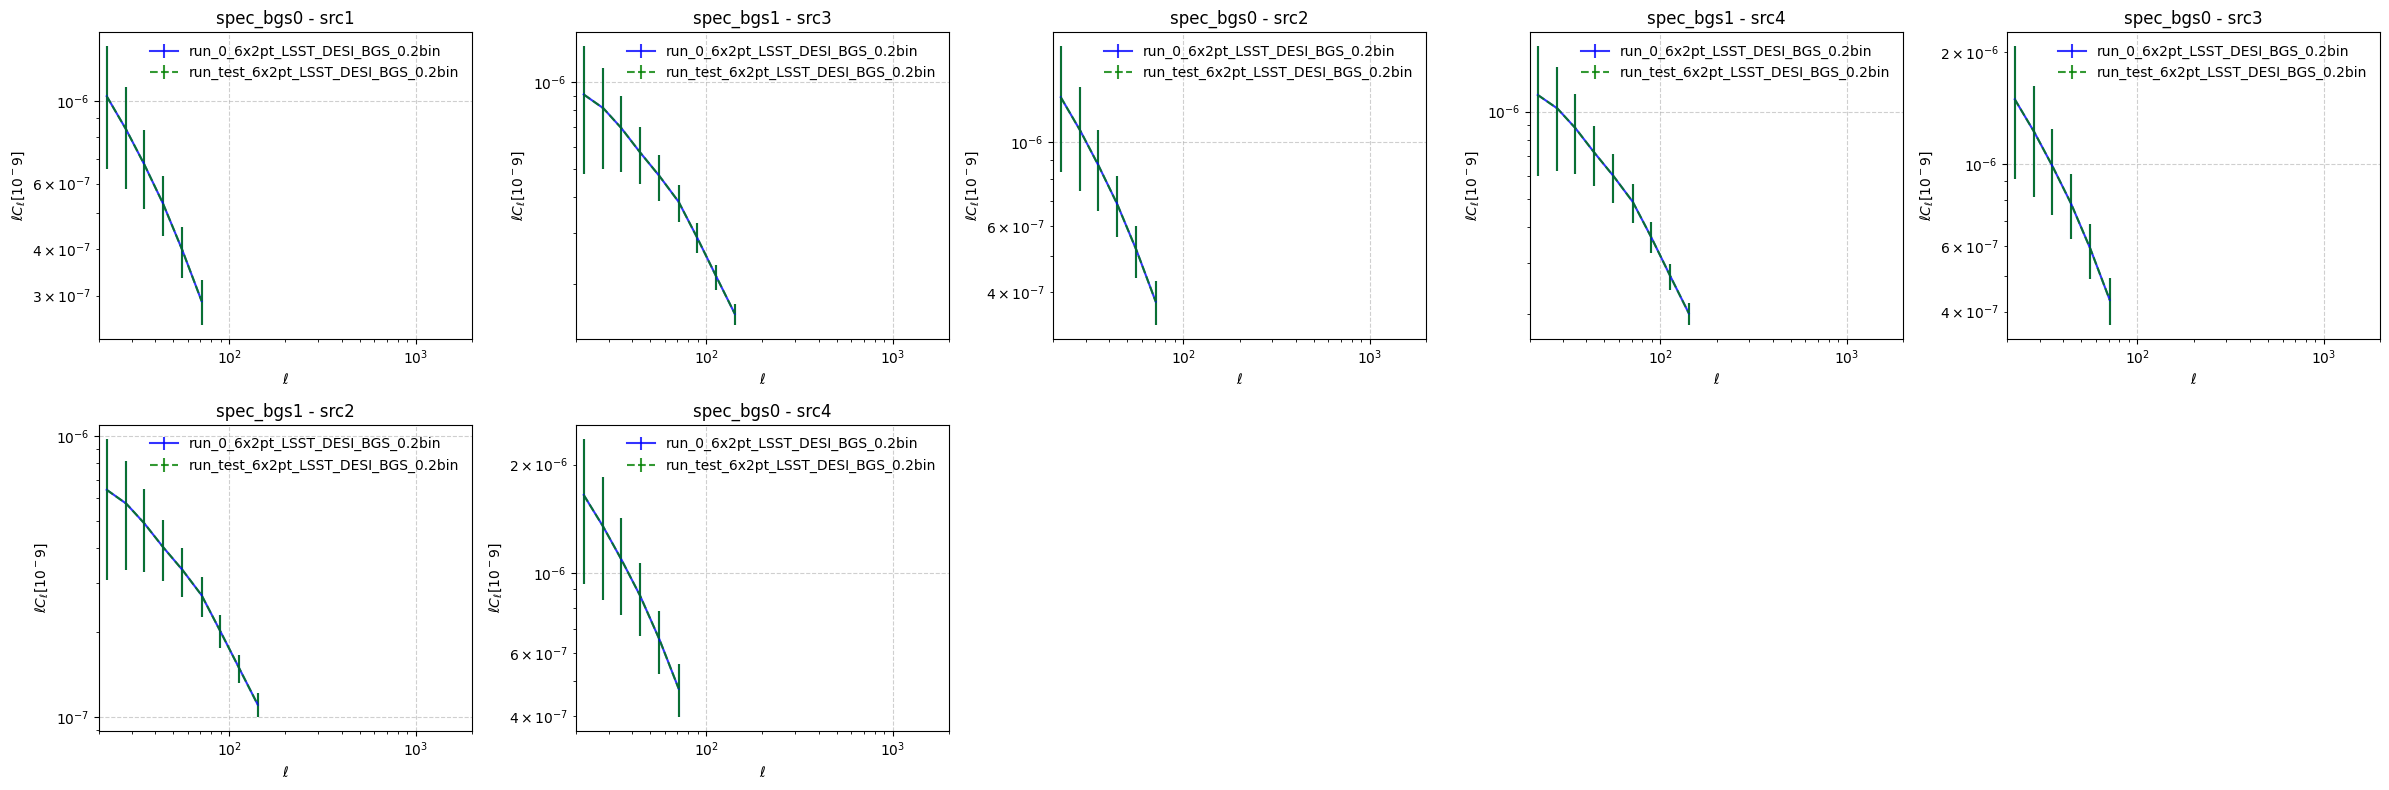

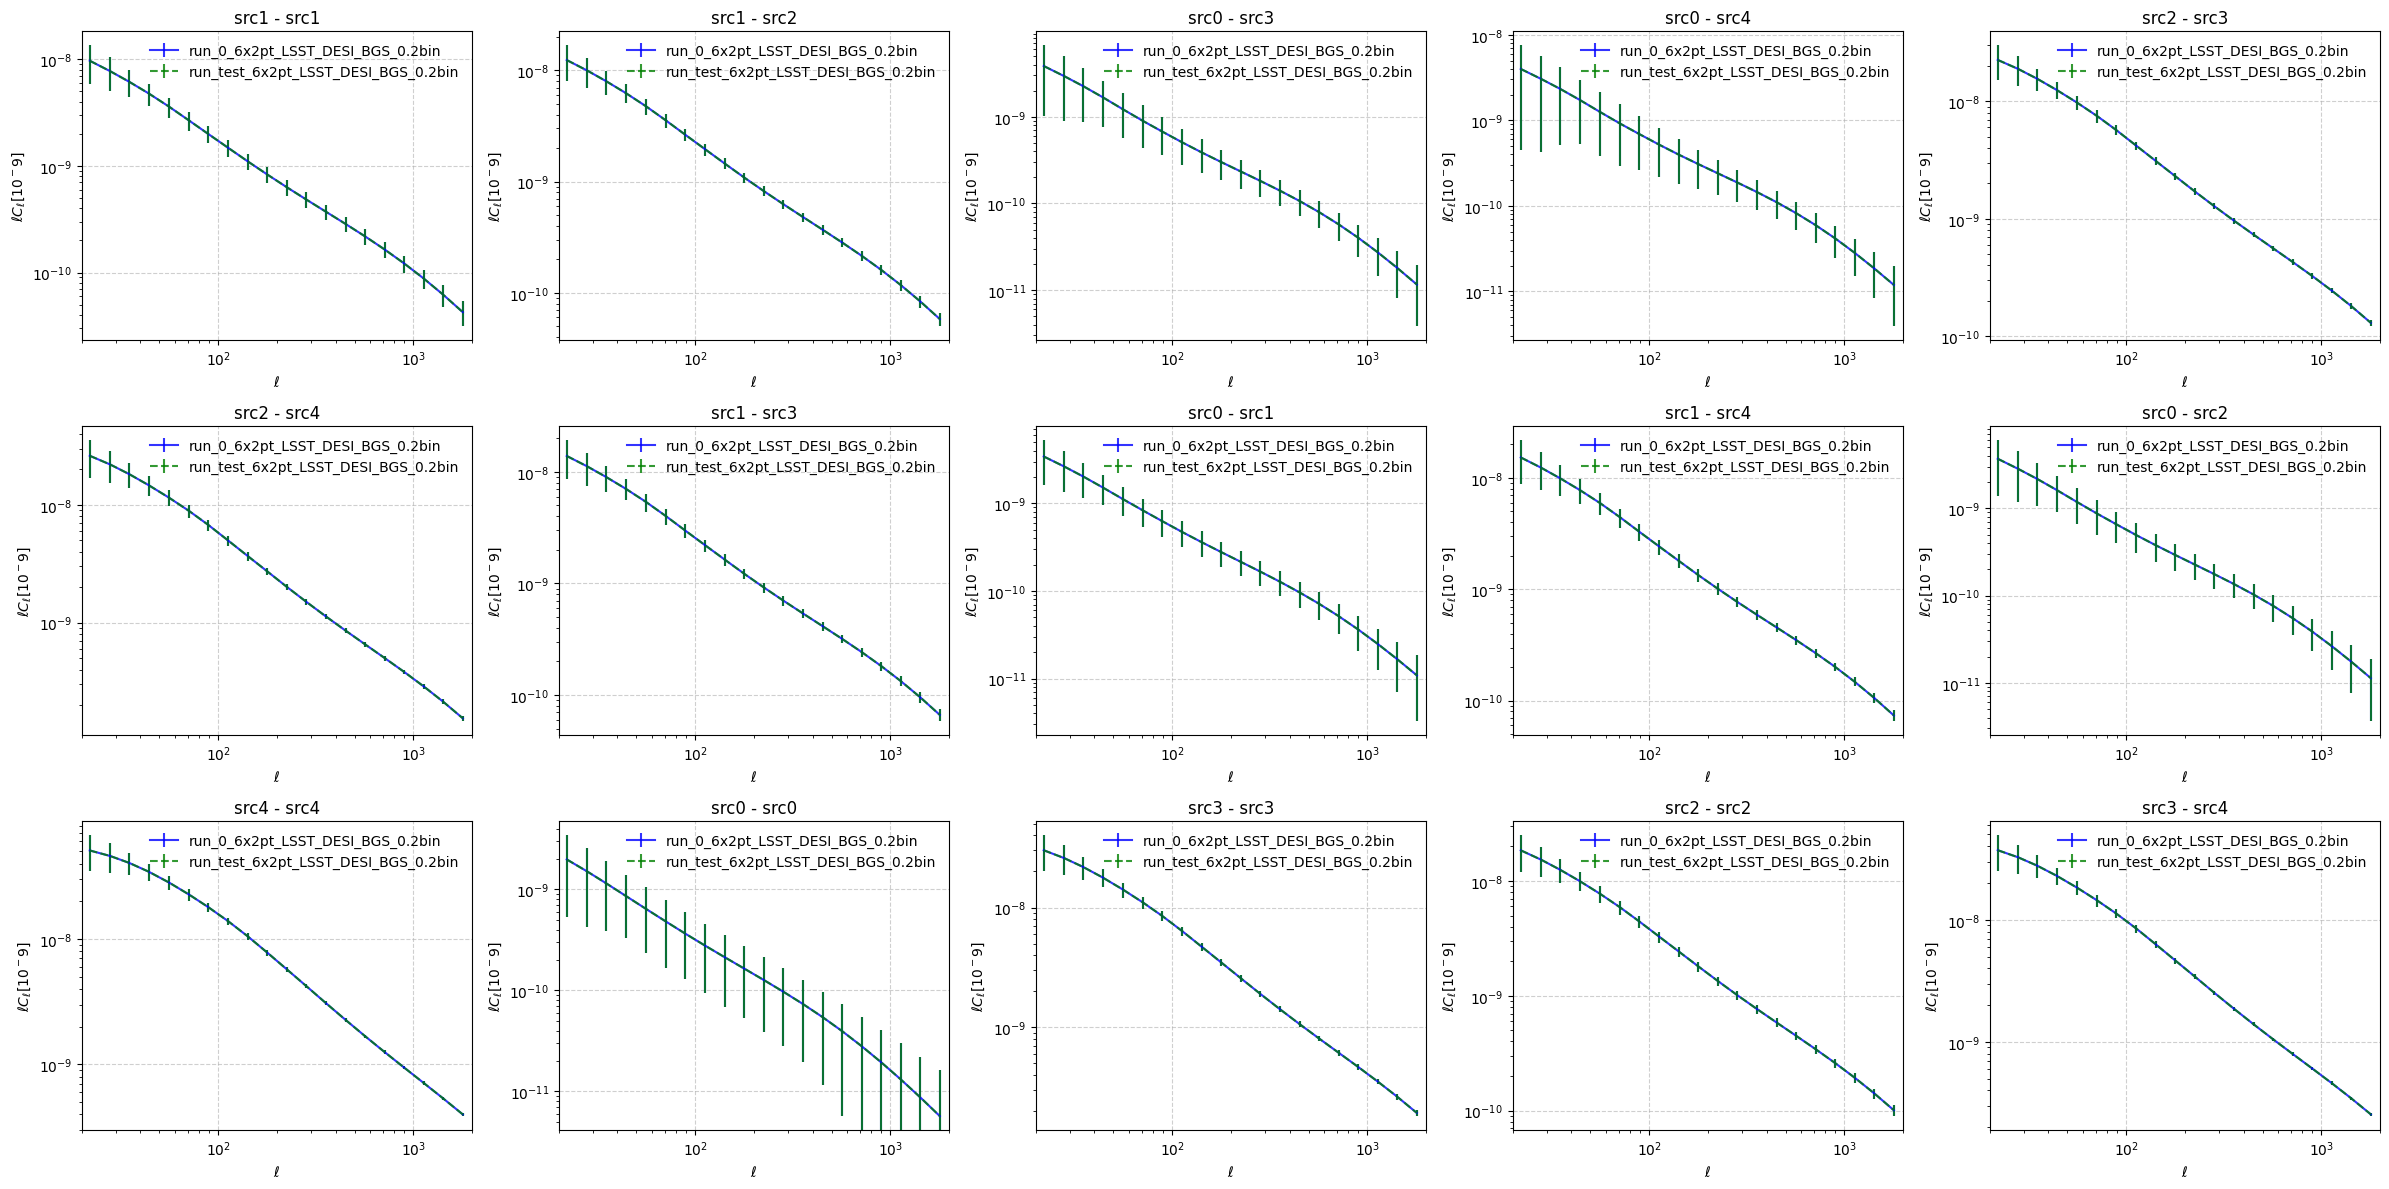

Indices for ('lens0', 'lens0'): [0 1 2 3 4 5 6 7]
Indices for ('lens1', 'lens1'): [ 8  9 10 11 12 13 14 15 16 17]
Indices for ('lens2', 'lens2'): [18 19 20 21 22 23 24 25 26 27 28]
Indices for ('lens3', 'lens3'): [29 30 31 32 33 34 35 36 37 38 39 40]
Indices for ('lens4', 'lens4'): [41 42 43 44 45 46 47 48 49 50 51 52 53]
Indices for ('spec_bgs0', 'lens0'): [54 55 56 57 58 59]
Indices for ('spec_bgs0', 'spec_bgs0'): [60 61 62 63 64 65]
Indices for ('spec_bgs1', 'lens0'): [66 67 68 69 70 71 72 73 74]
Indices for ('spec_bgs1', 'lens1'): [75 76 77 78 79 80 81 82 83]
Indices for ('spec_bgs1', 'spec_bgs1'): [84 85 86 87 88 89 90 91 92]
Indices for ('lens0', 'src2'): [ 93  94  95  96  97  98  99 100]
Indices for ('lens0', 'src3'): [101 102 103 104 105 106 107 108]
Indices for ('lens0', 'src4'): [109 110 111 112 113 114 115 116]
Indices for ('lens1', 'src3'): [117 118 119 120 121 122 123 124 125 126]
Indices for ('lens1', 'src4'): [127 128 129 130 131 132 133 134 135 136]
Indices for ('lens2'

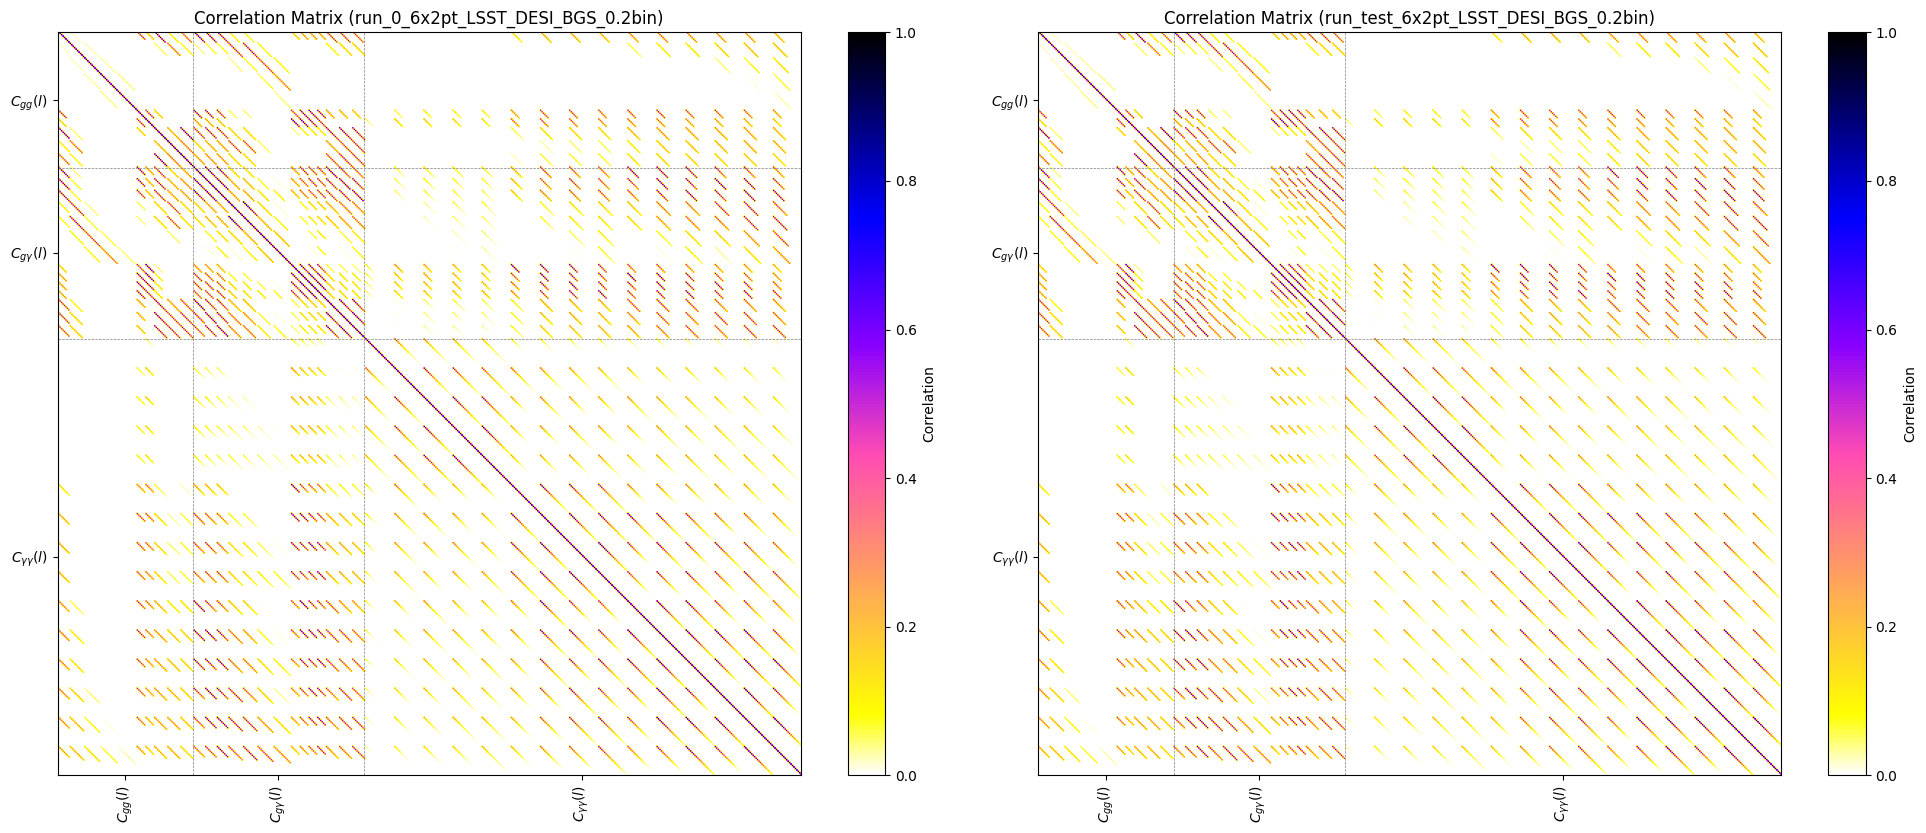

In [4]:
# all this functions just support plot4 runs

get_sacc_plots(['run_0_6x2pt_LSST_DESI_BGS_0.2bin', 'run_test_6x2pt_LSST_DESI_BGS_0.2bin'])
#get_chain_plots(['run_0_3x2pt_LSST', 'run_0_6x2pt_LSST_DESI_BGS_0.2bin', 'run_0_6x2pt_LSST_DESI_LRG_0.2bin', 'run_0_6x2pt_LSST_DESI_ELG_0.2bin'])

IndexError: list index out of range

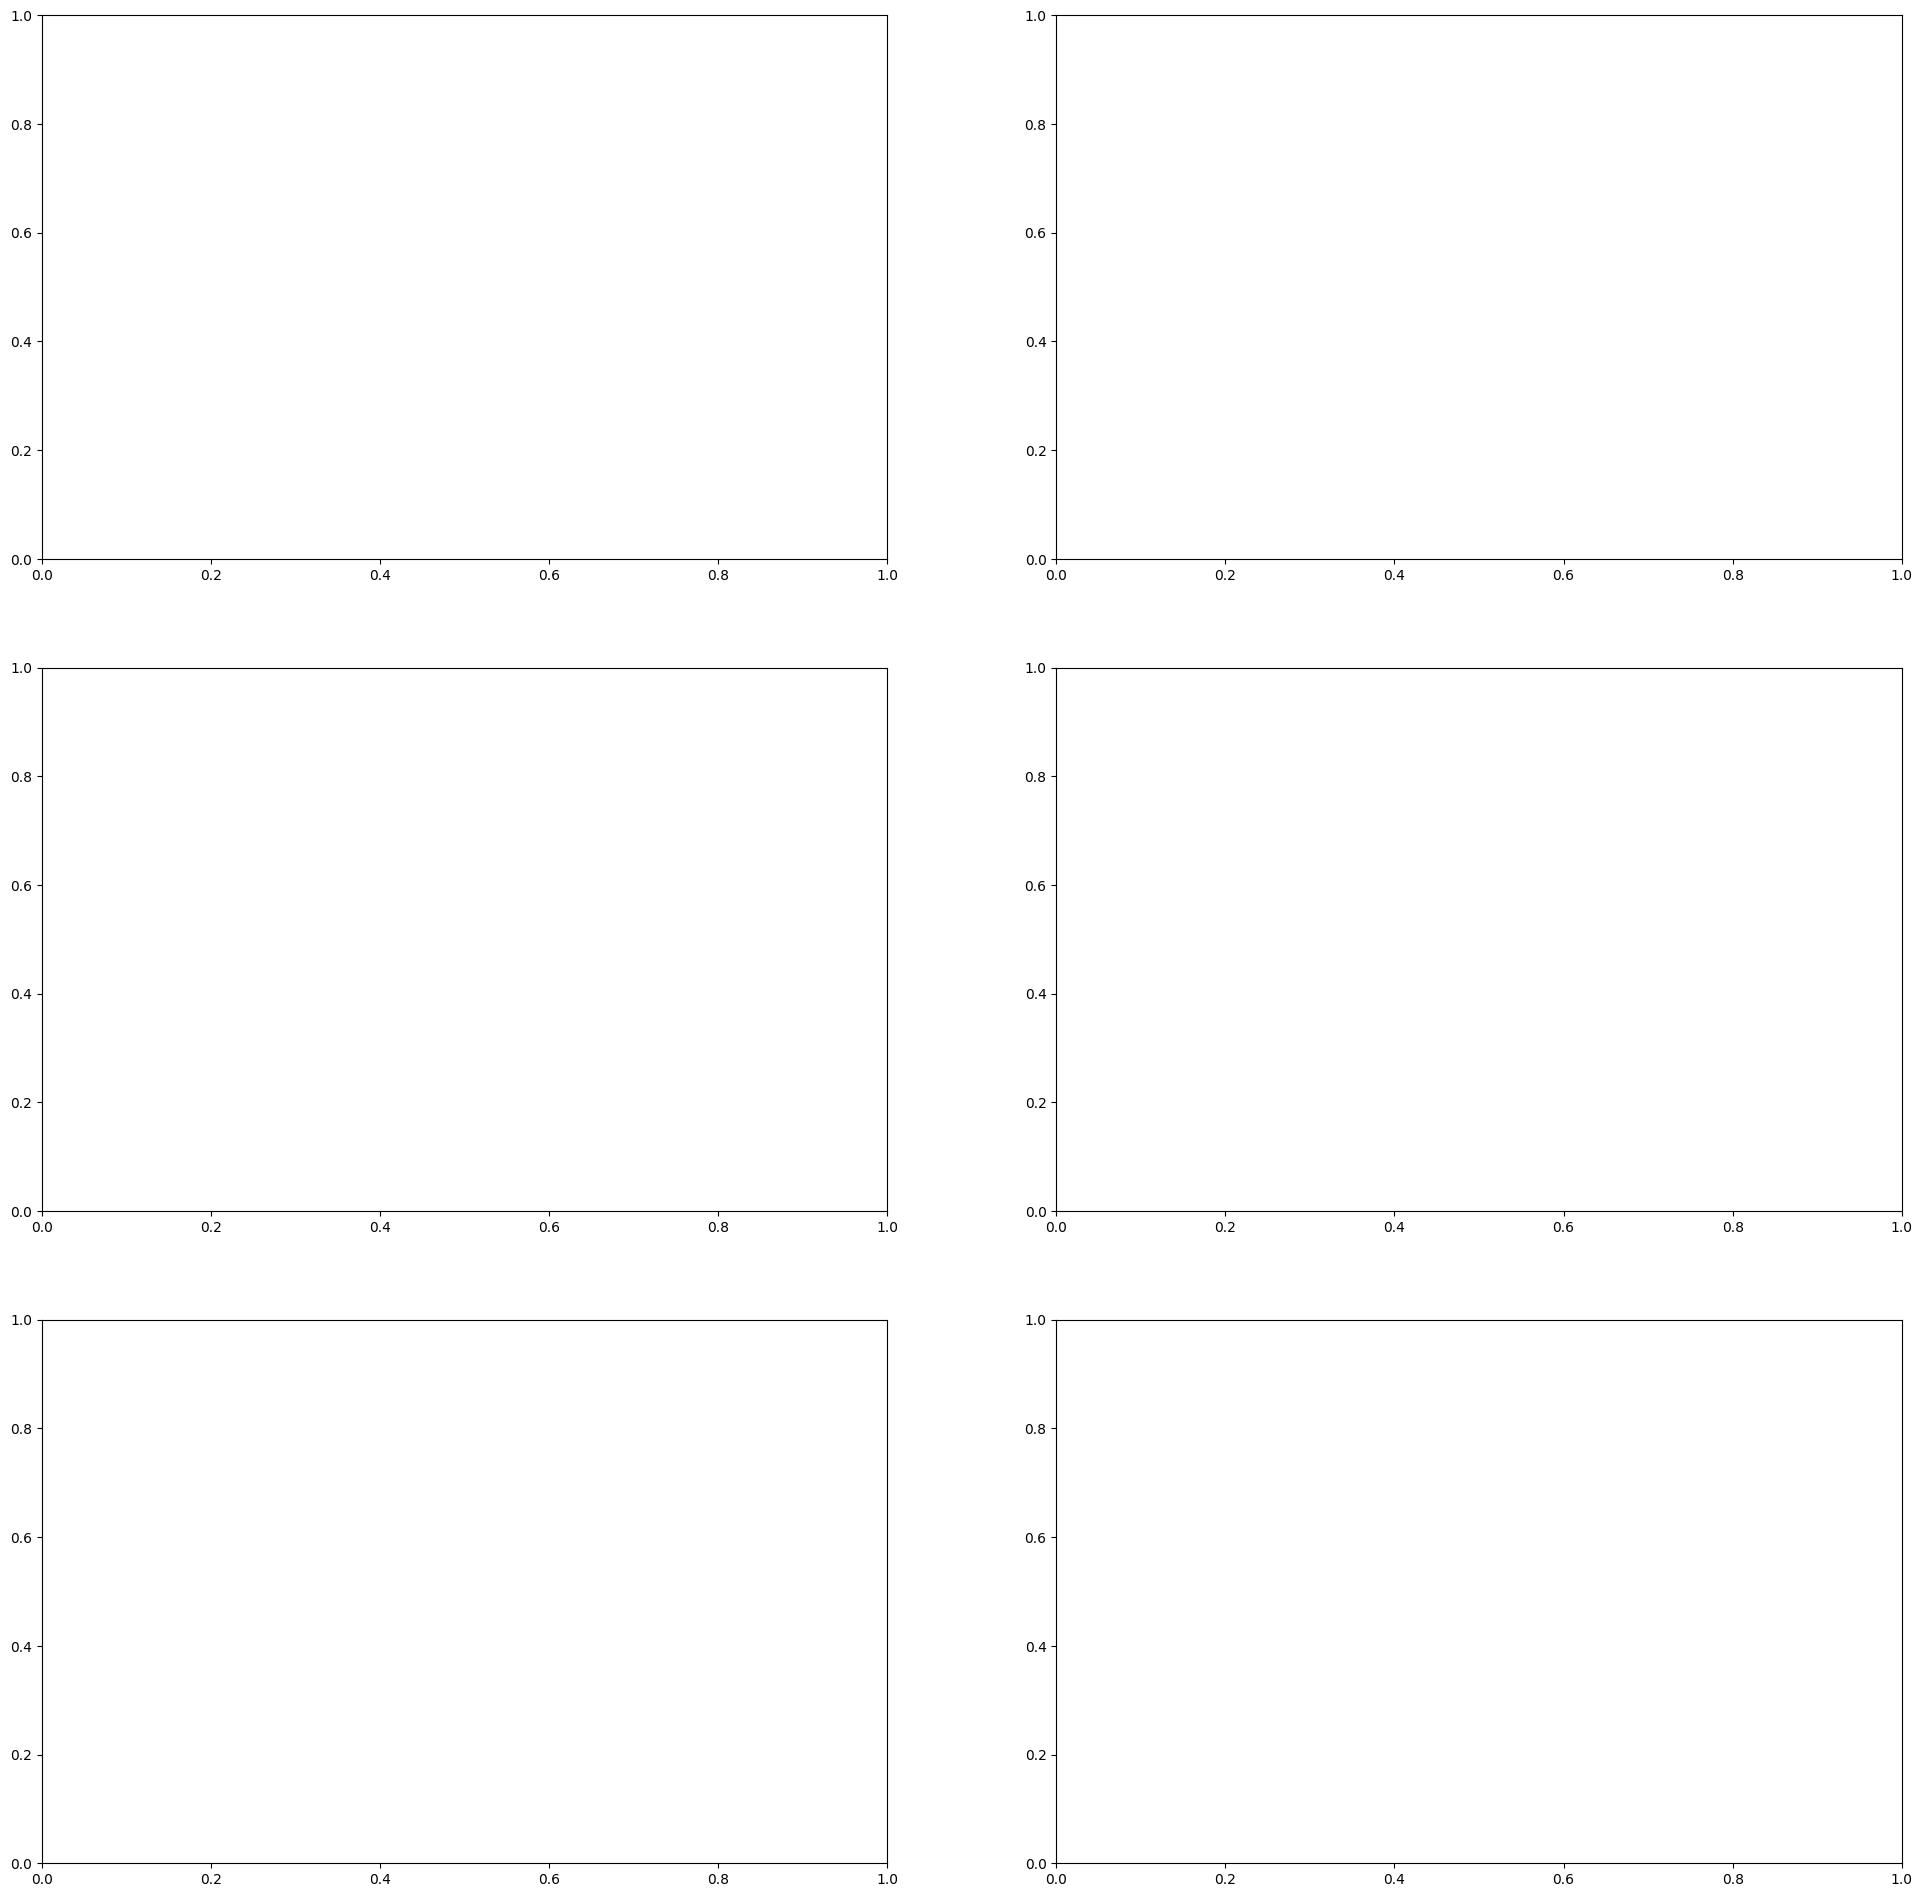

In [5]:
import numpy as np
import matplotlib.pyplot as plt

all_tracer_combinations = [
    ("lens4", "lens4"), ("spec_elg1", "lens3"), ("spec_lrg2", "spec_lrg2"),
    ("lens0", "src2"), ("spec_bgs1", "src3"), ("src1", "src1")
]

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(24, 24))
sacc_data1 = get_6x2pt_sacc(["run_0_6x2pt_LSST_DESI_FULL_0.2bin"])[0]

# Define custom ticks for log-scale axes
x_ticks = [20, 50, 100, 200, 500, 1000, 2000]  # Manually chosen ℓ values

for idx, (tr1, tr2) in enumerate(all_tracer_combinations):
    ell, C_ell, cov = sacc_data1.get_ell_cl(None, tr1, tr2, return_cov=True)
    err = np.sqrt(np.diag(cov))
    row, col = divmod(idx, 2)
    
    ax[row, col].errorbar(ell, C_ell, err, fmt='-o', markersize=4, capsize=3, label=f"{tr1}-{tr2}")
    ax[row, col].set_xscale("log")
    ax[row, col].set_yscale("log")
    ax[row, col].set_xlim(20, 2000)
        
    ax[row, col].set_xlabel("$\ell$", fontsize=12)
    ax[row, col].set_ylabel("$C_\ell$", fontsize=12)
    
    # Set titles and labels
    if tr1.startswith("lens") and tr2.startswith("lens"):
        y_ticks = [1e-5, 8e-6, 6e-6, 4e-6, 2e-6]
        ax[row, col].set_title("LSST Lens - LSST Lens", fontsize=14)
    elif tr1.startswith("spec") and tr2.startswith("lens"):
        y_ticks = [1e-5, 8e-6, 6e-6, 4e-6, 2e-6]
        ax[row, col].set_title("DESI ELG - LSST Lens", fontsize=14)
    elif tr1.startswith("spec") and tr2.startswith("spec"):
        y_ticks = [6e-5, 4e-5, 2e-5, 1e-5, 8e-6]
        ax[row, col].set_title("DESI LRG - DESI LRG", fontsize=14)
    elif tr1.startswith("lens") and tr2.startswith("src"):
        y_ticks = [8e-7, 6e-7, 4e-7, 2e-7, 1e-7]
        ax[row, col].set_title("LSST Lens - LSST Source", fontsize=14)
    elif tr1.startswith("spec") and tr2.startswith("src"):
        y_ticks = [1e-6, 8e-7, 6e-7, 4e-7, 2e-7, 1e-7]
        ax[row, col].set_title("DESI BGS - LSST Source", fontsize=14)
    elif tr1.startswith("src") and tr2.startswith("src"):
        y_ticks = [1e-8, 8e-9, 6e-9, 4e-9, 2e-9, 1e-9, 8e-10, 6e-10, 4e-10, 2e-10, 1e-10, 8e-11, 6e-11, 4e-11]
        ax[row, col].set_title("LSST Source - LSST Source", fontsize=14)
    
    ax[row, col].set_xticks(x_ticks)
    ax[row, col].set_xticklabels([f"{x}" for x in x_ticks])
    ax[row, col].set_yticks(y_ticks)
    ax[row, col].set_yticklabels([f"{y:.1e}" for y in y_ticks])
    ax[row, col].grid(True, linestyle="--", alpha=0.6)
    ax[row, col].legend(loc='upper right', fontsize=18 ,frameon=False)  # Add legend for each subplot

plt.tight_layout()
plt.show()


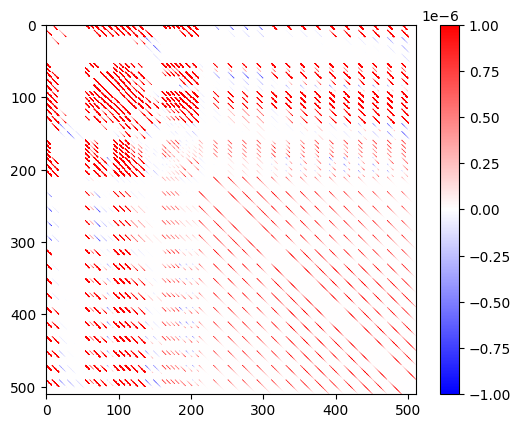

In [7]:
import pandas as pd
import numpy as np
import scipy as scp

# Assuming sacc_data1 and cov1 are already defined as in your code
sacc_data1 = get_6x2pt_sacc(["run_0_6x2pt_LSST_DESI_BGS_0.2bin"])[0]
cov1 = sacc_data1.covariance.dense
sig1 = np.sqrt(cov1.diagonal())
corr1 = cov1 / np.outer(sig1, sig1)

sacc_data2 = get_6x2pt_sacc(["run_test_6x2pt_LSST_DESI_BGS_0.2bin"])[0]
cov2 = sacc_data2.covariance.dense
sig2 = np.sqrt(cov2.diagonal())
corr2 = cov2 / np.outer(sig2, sig2)
plt.imshow(corr1 - corr2, vmin=-0.000001, vmax=0.000001, cmap='bwr')
plt.colorbar()
plt.show()
# Create a list of tracer cExceptionombinfrom scipy.signal import convolveations
tracer_combinations = {}
for dt in sacc_data1.get_data_types():
    for tr in sacc_data1.get_tracer_combinations(dt):
        tracer_combinations[f"{tr[0]}-{tr[1]}"] = sacc_data1.indices(dt, tr)

# Create labels for the DataFrame
labels = [f"{key}_{value}" for key, value in tracer_combinations.items()]

labels = []
for key in tracer_combinations:
    for value in tracer_combinations[key]:
        labels.append(f"{value}_{key}")
# Create a DataFrame with the covariance matrix and index/columns as tracer combinations
cov_df = pd.DataFrame(cov1, index=labels, columns=labels)
#cov_df.to_csv("cov_6x2pt_ELG_0.2bin.csv")


# cov_df = pd.read_csv("cov_6x2pt_ELG_0.2bin.csv", index_col=0)
# print(cov_df.index)
# print(cov_df.loc["0_lens0-lens0": "7_lens0-lens0", "0_lens0-lens0" : "7_lens0-lens0"])



### Signal to Noise


In [16]:
from fourrier_covariance_fsky import FirecrownFourierGaussianFsky
from config_builder import ConfigBuilder, load_yaml_file
from firecrown.parameters import ParamsMap
from utils import build_modeling_tools
import os
os.chdir("6x2pt/6x2pt_LSST_DESI_ELG_0.2bin/") 
cfg = ConfigBuilder(load_yaml_file("general.yaml"))  
cfg.config_builder()
ells_edges = np.linspace(
    cfg.array_config["ell_array"]["ell_start"],
    cfg.array_config["ell_array"]["ell_stop"],
    cfg.array_config["ell_array"]["ell_bins"] + 1,
    endpoint=True,
).astype(np.int32)
tools = build_modeling_tools(cfg.cosmo_config)
params = ParamsMap(cfg.firecrown_params)
os.chdir("../../")
sacc_data1 = get_6x2pt_sacc(["run_0_6x2pt_LSST_DESI_ELG_0.2bin"])[0]

cov_config = FirecrownFourierGaussianFsky(
    tools=tools,
    ell_edges=ells_edges,
    sacc_data=sacc_data1,
    factories=cfg.factories_config,
    parameters=params,
    probes_cfg=cfg.probes_config,
)
Noise_ = cov_config.get_noise_info()
for dt in sacc_data1.get_data_types():
    for tr1, tr2 in sacc_data1.get_tracer_combinations(dt):
        if tr1.startswith("spec") and tr2.startswith("spec"):
            ell, C_ell = sacc_data1.get_ell_cl(None, tr1, tr2)
            plt.plot(ell, C_ell, label=f"{tr1}-{tr2}")
            if tr1 == tr2:
                Noise = np.full(len(ell), Noise_[tr1])
                plt.plot(ell, Noise, label=f"{tr1}-{tr2}_Noise")
            plt.plot()
            plt.legend()
            plt.xscale("log")
            plt.yscale("log")
            plt.xlabel("$\ell$")
            plt.ylabel("$C_\ell$")
            plt.title("C_ell")
            plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '6x2pt/6x2pt_LSST_DESI_ELG_0.2bin/'

#### Forma de retirar ngal spec no photo


In [218]:
ngal_dict = {}
prp_cfg = load_yaml_file("6x2pt/6x2pt_LSST_DESI_FULL_0.05bin/config_yamls/probes_properties.yaml")
for survey in prp_cfg["probes"]:
    if survey == "overlap" or survey == "include_rsd":
        continue
    for tracer in prp_cfg["probes"][survey]["tracers"].keys():
        for i, value in enumerate(prp_cfg["probes"][survey]["tracers"][tracer]["ngal"]):
            ngal_dict[f"{tracer}{i}"] = value


from scipy.signal import convolve
sacc_data1 = get_6x2pt_sacc(["run_0_6x2pt_LSST_DESI_FULL_0.05bin"])[0]
for trc1 in sacc_data1.tracers:
    if trc1.startswith("lens"):
        print(trc1)
        tracer1 = sacc_data1.get_tracer(trc1)
        ngal_list = []
        for trc2 in sacc_data1.tracers:
            if trc2.startswith("spec"):
                #print(f'    {trc2}')
                tracer2 = sacc_data1.get_tracer(trc2)
                overlap_area = np.trapz(np.minimum(tracer1.nz, tracer2.nz), tracer1.z)
                peso = (overlap_area/np.trapz(tracer1.nz, tracer1.z))
                ngal_eff = peso*ngal_dict[trc2]
                ngal_list.append(ngal_eff)
                # plt.plot(tracer1.z, tracer1.nz, label=trc1)
                # plt.plot(tracer2.z, tracer2.nz, label=trc2)
                # plt.plot(tracer1.z, np.minimum(tracer1.nz, tracer2.nz), label="overlap")
                # plt.legend()
                # plt.show()
        print(ngal_dict[trc1] - sum(ngal_list))

lens0
2.102116946964304
lens1
3.0478439726768216
lens2
3.053521516488836
lens3
2.569324144375065
lens4
1.980553073498447


In [219]:
1/(0.4*20)

0.125

In [220]:
1/0.4*20

50.0